In [1]:
from scw_compare import get_era5_lsm
from percent_mean_change import transform_from_latlon
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
from rasterio import features
from affine import Affine
import glob
import xarray as xr
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import genextreme
from tqdm import tqdm
import netCDF4 as nc
from ari import drop_duplicates
from scw_compare import rasterize
import warnings

In [2]:
def load(y1, y2, djf=False, annmax=True):
    '''
        Load ARI-relevant data for BARRA and ERA5, obtained through ECDF and EV analysis in ari.py. Option to load just from 
        Summer data. Option to load in CDF data created using the annual maxima
    '''
    
    path = "/g/data/eg3/ab4502/gev/"
    if annmax:
        annmaxstr="_annmax"
    else:
        annmaxstr=""
    if djf:
        barpa_gev = xr.open_dataset(path+"barpa_erai_access_gev_djf_"+str(y1)+"_2015.nc")
        barpa_cdf = xr.open_dataset(path+"barpa_erai_access_cdf_djf_"+str(y1)+"_2015"+annmaxstr+".nc")
        barpa_cdf_nrm = [ pd.read_csv(path+"barpa_erai_access_cdf_djf_"+str(y1)+"_2015_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
        barpa_max = xr.open_dataset(path+"barpa_erai_access_cdf_djf_"+str(y1)+"_2015.nc")
    else:
        barpa_gev = xr.open_dataset(path+"barpa_erai_access_gev_"+str(y1)+"_"+str(y2)+".nc")
        barpa_cdf = xr.open_dataset(path+"barpa_erai_access_cdf_"+str(y1)+"_"+str(y2)+annmaxstr+".nc")
        barpa_cdf_nrm = [ pd.read_csv(path+"barpa_erai_access_cdf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
        barpa_max = xr.open_dataset(path+"barpa_erai_access_cdf_"+str(y1)+"_"+str(y2)+".nc")
        
    if djf:
        erai_gev = xr.open_dataset(path+"erai_gev_djf_"+str(y1)+"_"+str(y2)+".nc")
        erai_cdf = xr.open_dataset(path+"erai_cdf_djf_"+str(y1)+"_"+str(y2)+annmaxstr+".nc")
        erai_cdf_nrm = [ pd.read_csv(path+"erai_cdf_djf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
        erai_max = xr.open_dataset(path+"erai_cdf_djf_"+str(y1)+"_"+str(y2)+".nc")
    else:
        erai_gev = xr.open_dataset(path+"erai_gev_"+str(y1)+"_"+str(y2)+".nc")
        erai_cdf = xr.open_dataset(path+"erai_cdf_"+str(y1)+"_"+str(y2)+annmaxstr+".nc")
        erai_cdf_nrm = [ pd.read_csv(path+"erai_cdf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]  
        erai_max = xr.open_dataset(path+"erai_cdf_"+str(y1)+"_"+str(y2)+".nc")
        
    return [barpa_gev, barpa_cdf, barpa_cdf_nrm, barpa_max, erai_gev, erai_cdf, erai_cdf_nrm, erai_max]   

def compute_lmom_gev(da, ari):
    '''
        From an xarray dataarray with variables containing shape, location and scale parameters for a GEV, return the values for a given ari
    '''
    
    n, m = da.c_lmom.shape
    out = np.zeros((n,m))
    c = da.c_lmom.values
    loc = da["loc_lmom"].values
    scale = da.scale_lmom.values
    p = 1 - (1 / ari)
    for i in tqdm(np.arange(n)):
        for j in (np.arange(m)):
                   out[i,j] = genextreme.isf(q=1-p, c=c[i,j], loc=loc[i,j], scale=scale[i,j])
                   
    return out

def compute_wei_lmom(da, ari):
    '''
        From an xarray dataarray with variables containing shape, location and scale parameters for a Weibull EV, return the values for a given ari
    '''
    
    n, m = da["cw_lmom"].shape
    out = np.zeros((n,m))
    c = da["cw_lmom"].values
    loc = da["locw_lmom"].values
    scale = da["scalew_lmom"].values
    p = 1 - (1 / ari)
    for i in tqdm(np.arange(n)):
        for j in (np.arange(m)):
                   out[i,j] = genextreme.isf(q=1-p, c=c[i,j], loc=loc[i,j], scale=scale[i,j])
                   
    return out

def compute_wei(da, ari):
    '''
        From an xarray dataarray with variables containing shape, location and scale parameters for a Weibull EV, return the values for a given ari
    '''
    
    n, m = da["cw"].shape
    out = np.zeros((n,m))
    c = da["cw"].values
    loc = da["locw"].values
    scale = da["scalew"].values
    p = 1 - (1 / ari)
    for i in tqdm(np.arange(n)):
        for j in (np.arange(m)):
                   out[i,j] = genextreme.isf(q=1-p, c=c[i,j], loc=loc[i,j], scale=scale[i,j])
                   
    return out

def compute_gev(da, ari):
    '''
        From an xarray dataarray with variables containing shape, location and scale parameters for a GEV, return the values for a given ari
    '''
    
    n, m = da.c.shape
    out = np.zeros((n,m))
    c = da.c.values
    loc = da["loc"].values
    scale = da.scale.values
    p = 1 - (1 / ari)
    for i in tqdm(np.arange(n)):
        for j in (np.arange(m)):
                   out[i,j] = genextreme.isf(q=1-p, c=c[i,j], loc=loc[i,j], scale=scale[i,j])
                   
    return out

def compute_lmom_gev_nrm(da):
    '''
        From the NRM-maximum annual time series-fitted GEV, compute the ARI
    '''
    T = (np.logspace(-1,3,1000))
    out =  [ genextreme.isf(q=1-(1-(1/T)), c=da.attrs["c_lmom_nrm"][i], loc=da.attrs["loc_lmom_nrm"][i], scale=da.attrs["scale_lmom_nrm"][i]) for i in np.arange(4) ]
    return [out, T]   

def compute_gev_nrm(da):
    '''
        From the NRM-maximum annual time series-fitted GEV, compute the ARI
    '''
    T = (np.logspace(-1,3,1000))
    out =  [ genextreme.isf(q=1-(1-(1/T)), c=da.attrs["nrm_c"][i], loc=da.attrs["nrm_loc"][i], scale=da.attrs["nrm_scale"][i]) for i in np.arange(4) ]
    return [out, T]   

def compute_lmom_wei_nrm(da):
    '''
        From the NRM-maximum annual time series-fitted GEV, compute the ARI
    '''
    T = (np.logspace(-1,3,1000))
    out =  [ genextreme.isf(q=1-(1-(1/T)), c=da.attrs["cw_lmom_nrm"][i], loc=da.attrs["locw_lmom_nrm"][i], scale=da.attrs["scalew_lmom_nrm"][i]) for i in np.arange(4) ]
    return [out, T]   

def compute_wei_nrm(da):
    '''
        From the NRM-maximum annual time series-fitted GEV, compute the ARI
    '''
    T = (np.logspace(-1,3,1000))
    out =  [ genextreme.isf(q=1-(1-(1/T)), c=da.attrs["nrm_cw"][i], loc=da.attrs["nrm_locw"][i], scale=da.attrs["nrm_scalew"][i]) for i in np.arange(4) ]
    return [out, T]   

def plot_borders(nrm_da):
    xr.plot.contour(xr.where(nrm_da["aus"]==1, 1, 0), levels=[0.5,1.5], colors="k", add_labels=False)
    #[xr.plot.contour(xr.where((nrm_da==i) & (~(nrm_da["aus"].isnull())), 1, 0), levels=[0.5,1.5], colors="k", add_labels=False) for i in [0,1,2,3]]


In [3]:
#LOAD DATA

ari=10
cdf_ari="ari10"
djf=False
annmax=True
barpa_gev, barpa_cdf, barpa_cdf_nrm, barpa_max, erai_gev, erai_cdf, erai_cdf_nrm, erai_max = \
        load(1990, 2015, djf)

barpa_lmom_ari = compute_lmom_gev(barpa_gev, ari)
barpa_ari_lmom_nrm, T = compute_lmom_gev_nrm(barpa_gev)

erai_lmom_ari = compute_lmom_gev(erai_gev, ari)
erai_ari_lmom_nrm, T = compute_lmom_gev_nrm(erai_gev)


100%|██████████| 46/46 [00:00<00:00, 96.05it/s]


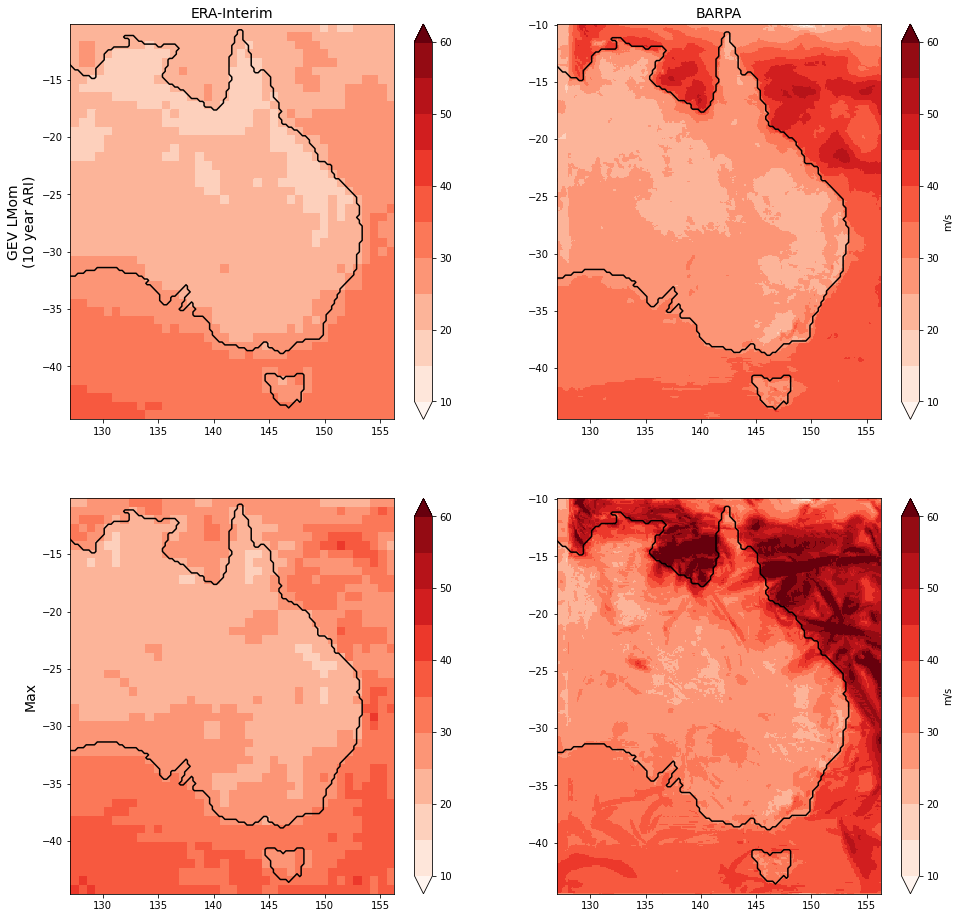

In [17]:
#PLOTTING - Spatial map of 10-year ARI and max wind gust

era5_range = [10,60]
barra_range = [10,60]
cmap = plt.get_cmap("Reds")
levels = 11
rows=5
cols=8

temp = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/ERA5__mean_lr36_historical_1979_2005.nc")
f = geopandas.read_file("/home/548/ab4502/NRM_super_clusters/NRM_super_clusters.shp")
f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
shapes = [(shape, n) for n, shape in enumerate(f.geometry)]
nrm_da = rasterize(shapes, {"lon":temp.lon,"lat":temp.lat})
nrm_da["aus"] = rasterize([f2.loc[f2.name=="Australia"].geometry.values[0]], {"lon":temp.lon,"lat":temp.lat})

fig=plt.figure(figsize=([16,16]))

#BARPA GEV LMOM
plt.subplot(2,2,2)
xr.DataArray(data=np.where(barpa_gev.lmom_fail==0, barpa_lmom_ari, np.nan), coords=(barpa_gev.lat, barpa_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", cbar_kwargs={"label":"m/s"})
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.title("BARPA", size=14)

#BARPA CDF
#plt.subplot(3,2,4);barpa_cdf[cdf_ari].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
#plot_borders(nrm_da)
#plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

#BARPA MAX
plt.subplot(2,2,4);barpa_max["max"].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False, cbar_kwargs={"label":"m/s"})
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

#ERAI GEV LMOM
plt.subplot(2,2,1)
xr.DataArray(data=np.where(erai_gev.lmom_fail==0, erai_lmom_ari, np.nan), coords=(erai_gev.lat, erai_gev.lon)).plot(xlim = [barpa_gev.lon.min(), barpa_gev.lon.max()], vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.ylabel("GEV LMom\n(10 year ARI)", rotation=90, size=14)
plt.title("ERA-Interim", size=14)

#ERAI CDF
#plt.subplot(3,2,3);erai_cdf[cdf_ari].plot(xlim = [barpa_gev.lon.min(), barpa_gev.lon.max()], vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
#plot_borders(nrm_da)
#plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
#plt.ylabel("CDF\n(10 year ARI)", rotation=90, size=14)

#ERAI MAX
plt.subplot(2,2,3);erai_max["max"].plot(xlim = [barpa_gev.lon.min(), barpa_gev.lon.max()], vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.ylabel("Max", rotation=90, size=14)

plt.subplots_adjust()
plt.savefig("/g/data/eg3/ab4502/figs/barpa/erai_compare_ari.png", bbox_inches="tight")

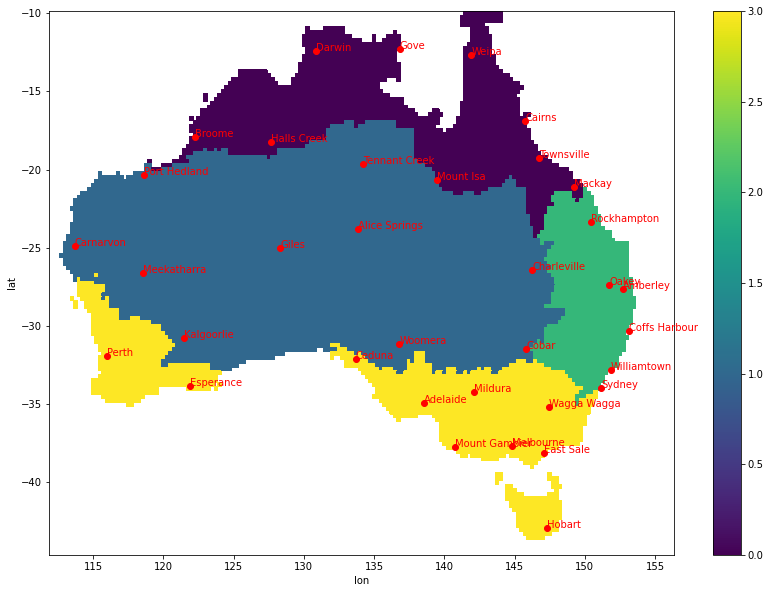

In [5]:
#Load AWS station information and data, plot stations

names = ["id", "stn_no", "district", "stn_name", "1", "2", "lat", "lon", "3", "4", "5", "6", "7", "8", \
"9", "10", "11", "12", "13", "14", "15", "16"]	
df = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/obs/aws/daily_aus_full/DC02D_StnDet_999999999643799.txt",\
names=names, header=0)
renames = {'ALICE SPRINGS AIRPORT                   ':"Alice Springs",\
'GILES METEOROLOGICAL OFFICE             ':"Giles",\
'COBAR MO                                ':"Cobar",\
'AMBERLEY AMO                            ':"Amberley",\
'SYDNEY AIRPORT AMO                      ':"Sydney",\
'MELBOURNE AIRPORT                       ':"Melbourne",\
'MACKAY M.O                              ':"Mackay",\
'WEIPA AERO                              ':"Weipa",\
'MOUNT ISA AERO                          ':"Mount Isa",\
'ESPERANCE                               ':"Esperance",\
'ADELAIDE AIRPORT                        ':"Adelaide",\
'CHARLEVILLE AERO                        ':"Charleville",\
'CEDUNA AMO                              ':"Ceduna",\
'OAKEY AERO                              ':"Oakey",\
'WOOMERA AERODROME                       ':"Woomera",\
'TENNANT CREEK AIRPORT                   ':"Tennant Creek",\
'GOVE AIRPORT                            ':"Gove",\
'COFFS HARBOUR MO                        ':"Coffs Harbour",\
'MEEKATHARRA AIRPORT                     ':"Meekatharra",\
'HALLS CREEK METEOROLOGICAL OFFICE       ':"Halls Creek",\
'ROCKHAMPTON AERO                        ':"Rockhampton",\
'MOUNT GAMBIER AERO                      ':"Mount Gambier",\
'PERTH AIRPORT                           ':"Perth",\
'WILLIAMTOWN RAAF                        ':"Williamtown",\
'CARNARVON AIRPORT                       ':"Carnarvon",\
'KALGOORLIE-BOULDER AIRPORT              ':"Kalgoorlie",\
'DARWIN AIRPORT                          ':"Darwin",\
'CAIRNS AERO                             ':"Cairns",\
'MILDURA AIRPORT                         ':"Mildura",\
'WAGGA WAGGA AMO                         ':"Wagga Wagga",\
'BROOME AIRPORT                          ':"Broome",\
'EAST SALE                               ':"East Sale",\
'TOWNSVILLE AERO                         ':"Townsville",\
'HOBART (ELLERSLIE ROAD)                 ':"Hobart",\
'PORT HEDLAND AIRPORT                    ':"Port Hedland"}
df = df.replace({"stn_name":renames})
points = [(df.lon.iloc[i], df.lat.iloc[i]) for i in np.arange(df.shape[0])]
temp = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/ERA5__mean_lr36_historical_1979_2005.nc")
f = geopandas.read_file("/home/548/ab4502/NRM_super_clusters/NRM_super_clusters.shp")
f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
shapes = [(shape, n) for n, shape in enumerate(f.geometry)]
nrm_da = rasterize(shapes, {"lon":temp.lon,"lat":temp.lat})
nrm_da["aus"] = rasterize([f2.loc[f2.name=="Australia"].geometry.values[0]], {"lon":temp.lon,"lat":temp.lat})
names = ["record_id","stn_no","stn_name","locality", "state","lat","lon","height","date_str",\
                "wind_gust","quality","wind_dir", "wind_dir_quality", "max_gust_str_lt", \
                "max_gust_time_quality", "eof"]
data_types = dict(record_id=str, stn_no=int, stn_name=str, locality=str, state=str, lat=float, lon=float,\
                                height=str, date_str=str, wind_gust=float, quality=str, \
                                wind_dir=str, wind_dir_quality=str, max_gust_str_lt=str,\
                                max_gust_time_quality=str,\
                                eof=str)
f = "/g/data/eg3/ab4502/ExtremeWind/obs/aws/daily_aus_full/DC02D_Data_999999999720188.txt"
obs = pd.read_csv(f, names=names, dtype=data_types, na_values={"wind_gust":'     ', "max_gust_str_lt":"    "})
obs = obs.replace({"stn_name":renames})
obs["wind_dir"] = obs["wind_dir"].str.strip()
obs["wind_dir"] = pd.to_numeric(obs.wind_dir, errors="coerce")
obs["stn_name"] = obs["stn_name"].str.strip()
obs["year"] = obs.date_str.str.slice(6,10).astype("int")
obs["month"] = obs.date_str.str.slice(3,5).astype("int")
obs["day_lt"] = obs.date_str.str.slice(0,2).astype("int")
obs["daily_date_lt"] = pd.to_datetime({"year":obs["year"],"month":obs["month"],"day":obs["day_lt"]})
fig = plt.figure(figsize=[14,10])
ax = plt.gca()
nrm_da.plot(ax=ax)
for i in np.arange(len(points)):
    x, y = points[i]
    n = df.iloc[i]["stn_name"]
    ax.text(x, y, n, color="red")
    ax.plot(x,y,marker="o",color="red")
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/stn_map.png", bbox_inches="tight")

In [6]:
#Plot ARI comparison between BARRA, BARPA and station data

def compare_with_obs(loc_name):

    stn_lon = df[df.stn_name==loc_name]["lon"]
    stn_lat = df[df.stn_name==loc_name]["lat"]

    #BARPA
    topog = xr.open_dataset("/g/data/du7/barpa/trials/BARPA-EASTAUS_12km/static/topog-BARPA-EASTAUS_12km.nc")["topog"].interp({"latitude":barpa_gev.lat, "longitude":barpa_gev.lon}, "nearest")
    lsm_barp = ((topog.values) > 0) * 1
    a,b = np.meshgrid(barpa_gev.lon, barpa_gev.lat)
    a[lsm_barp==0] = np.nan
    b[lsm_barp==0] = np.nan
    dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
    temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

    c = barpa_gev["c"].isel({"lat":temp_lat, "lon":temp_lon})
    loc = barpa_gev["loc"].isel({"lat":temp_lat, "lon":temp_lon})
    scale = barpa_gev["scale"].isel({"lat":temp_lat, "lon":temp_lon})
    p = np.linspace(0,1,10000)
    barp_T = 1/(1-p)
    barp_x = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
    barp_x_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/barpa_erai_annmax_annual_1990_2015.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
    barp_T_raw = (1 / (1 - ECDF(barp_x_raw).y))

    #ERAI
    topog = xr.open_dataset("/g/data/eg3/ab4502/erai_lsm.nc")["lsm"].interp({"latitude":erai_gev.lat, "longitude":erai_gev.lon}, "nearest")
    lsm_erai = (np.squeeze(topog.values) > 0) * 1
    a,b = np.meshgrid(erai_gev.lon, erai_gev.lat)
    a[lsm_erai==0] = np.nan
    b[lsm_erai==0] = np.nan
    dist = np.sqrt(np.square(a-stn_lon.values[0]) + \
                        np.square(b-stn_lat.values[0]))
    temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist),dist.shape)

    c = erai_gev["c"].isel({"lat":temp_lat, "lon":temp_lon})
    loc = erai_gev["loc"].isel({"lat":temp_lat, "lon":temp_lon})
    scale = erai_gev["scale"].isel({"lat":temp_lat, "lon":temp_lon})
    p = np.linspace(0,1,10000)
    erai_T = 1/(1-p)
    erai_x = np.squeeze(genextreme.isf(q=1-p, c=c, loc=loc, scale=scale))
    erai_x_raw = np.sort(xr.open_dataset("/g/data/eg3/ab4502/gev/erai_annmax_annual_1990_2015.nc")["da"].isel({"lat":temp_lat, "lon":temp_lon}).values)
    erai_T_raw = (1 / (1 - ECDF(erai_x_raw).y))

    #OBS
    obs_x = np.sort(obs[obs.stn_name==loc_name][["daily_date_lt", "wind_gust"]].iloc[:-1].resample("1Y", on="daily_date_lt").max()["wind_gust"].values)
    obs_T = (1 / (1 - ECDF(obs_x).y))
    c,loc,scale = genextreme.fit(obs_x)
    p = np.linspace(0,1,10000)
    obs_fit_x = genextreme.isf(q=1-p, c=c, loc=loc, scale=scale)
    obs_fit_T = 1/(1-p)

    plt.plot(barp_T, barp_x, label="BARPA")
    plt.plot(barp_T_raw[:-1], barp_x_raw, marker="x", linestyle="none", color="tab:blue")
    plt.plot(erai_T, erai_x, label="ERAI")
    plt.plot(erai_T_raw[:-1], erai_x_raw, marker="x", linestyle="none", color="tab:orange")

    plt.plot(obs_fit_T, obs_fit_x, color="k", label="AWS" )
    plt.plot(obs_T[:-1], obs_x, marker="x", color="k", linestyle="none")
    plt.ylim([10,50])
    plt.xlim([1,200])
    plt.xscale("log")
    plt.title(loc_name, size=14)
    plt.legend(fontsize=12)
    ax=plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.xlabel("Return period (years)", size=12)
    plt.ylabel("10 m wind gust (m/s)", size=12)


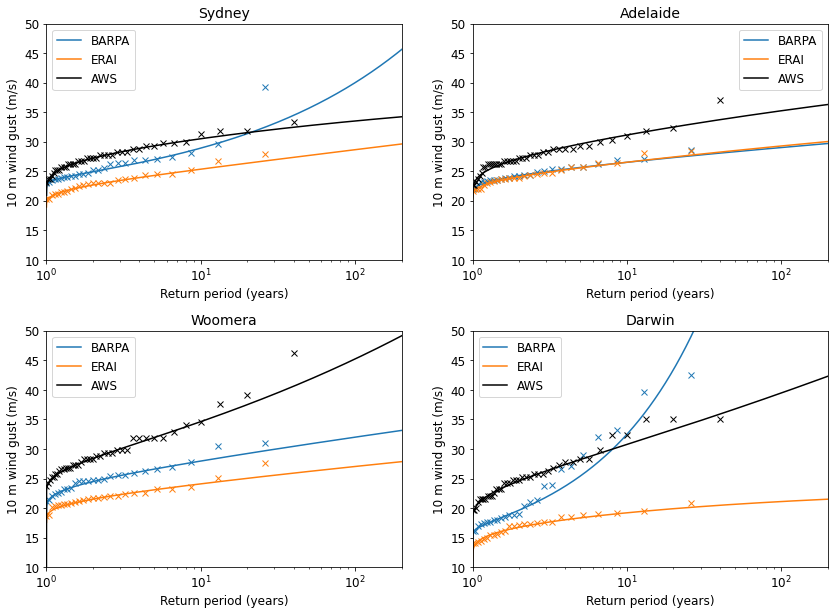

In [9]:
warnings.simplefilter("ignore")
plt.figure(figsize=[14,10])
plt.subplot(2,2,1);compare_with_obs("Sydney")
plt.subplot(2,2,2);compare_with_obs("Adelaide")
plt.subplot(2,2,3);compare_with_obs("Woomera")
plt.subplot(2,2,4);compare_with_obs("Darwin")
plt.subplots_adjust(hspace=0.3)
plt.savefig("/g/data/eg3/ab4502/figs/barpa/erai_stn_compare_ari.png", bbox_inches="tight")

In [60]:
plt.legend?

Signature: plt.legend(*args, **kwargs)
Docstring:
Place a legend on the axes.

Call signatures::

    legend()
    legend(labels)
    legend(handles, labels)

The call signatures correspond to three different ways how to use
this method.

**1. Automatic detection of elements to be shown in the legend**

The elements to be added to the legend are automatically determined,
when you do not pass in any extra arguments.

In this case, the labels are taken from the artist. You can specify
them either at artist creation or by calling the
:meth:`~.Artist.set_label` method on the artist::

    line, = ax.plot([1, 2, 3], label='Inline label')
    ax.legend()

or::

    line, = ax.plot([1, 2, 3])
    line.set_label('Label via method')
    ax.legend()

Specific lines can be excluded from the automatic legend element
selection by defining a label starting with an underscore.
This is default for all artists, so calling `Axes.legend` without
any arguments and without setting the labels manually will 